In [1]:
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

def show_img(img: np.ndarray) -> None:
    plt.figure(figsize=(20,10))
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img[...,::-1])

In [2]:
file = Path().resolve().parent.parent / 'imgs-test' / 'middle.JPG'
file.is_file()

True

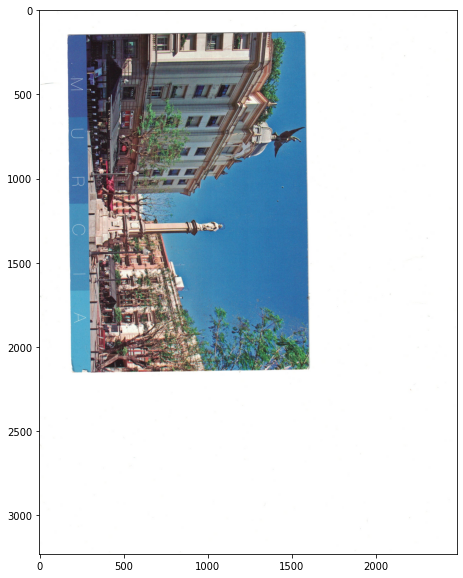

In [3]:
img = cv.imread(str(file), 1)
show_img(img)

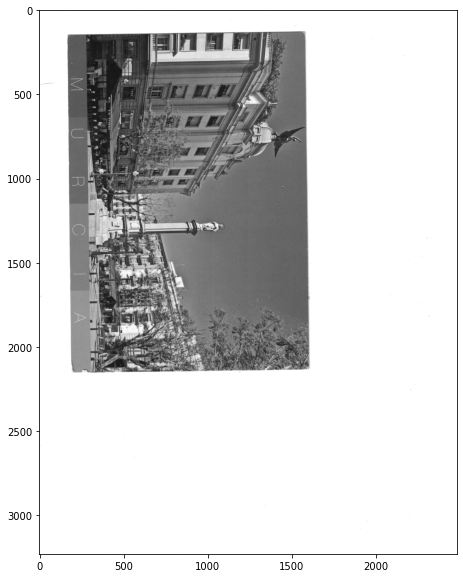

In [4]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
show_img(img_gray)

In [5]:
ret, thresh = cv.threshold(img_gray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print(f"contours:  {type(contours)}, {len(contours)}")
print(f"hierarchy: {type(hierarchy)}, {len(hierarchy)}")
print(hierarchy[0][0], cv.contourArea(contours[0]))

contours:  <class 'tuple'>, 71890
hierarchy: <class 'numpy.ndarray'>, 1
[-1 -1  1 -1] 8007170.0


In [6]:
# h = hierarchy[0]
# for i in range(20):
    # print(f"{i} {h[i]} {cv.contourArea(contours[i])}")

In [7]:
c = []

for idx, val in enumerate(hierarchy[0]):
    _next, _prev, _child, _parent = val
    if _next == -1 and _child != -1 and _parent == 0:
        c.append((idx, val))
        
print(len(c))

1


In [8]:
for i in c:
    print(f"{i} -> {cv.contourArea(contours[i[0]])}")

(11156, array([   -1, 11155, 11157,     0], dtype=int32)) -> 2616676.0


In [9]:
photos = []
for idx, val in enumerate(hierarchy[0]):
    _next, _prev, _child, _parent = val
    if _next == -1 and _parent == 0 and _child != -1:
        photos.append(contours[idx])

print(f"photos len = {len(photos)}")        
photo_contour = photos[0]
photo_contour_area = cv.contourArea(photo_contour)
print(f"photo_contour: {type(photo_contour)}, {len(photo_contour)}")
print(f"photo_contour_area: {photo_contour_area}")

photos len = 1
photo_contour: <class 'numpy.ndarray'>, 9100
photo_contour_area: 2616676.0


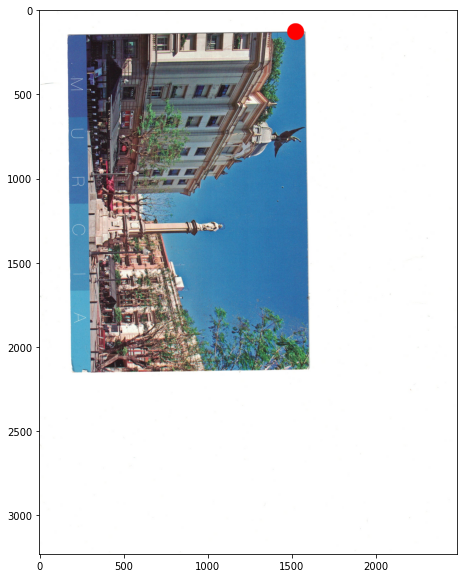

In [10]:
rect = cv.minAreaRect(photo_contour)
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(img, photo_contour, 0, (0,0,255), 100);
show_img(img)